In [1]:
import sys
sys.path.append('/Users/apple/Documents/ML_Project/ML - 2.1/')
import numpy as np
import pandas as pd
from module.utils import *
from ngboost.learners import *
from tqdm.notebook import tqdm as tqdm
from sklearn.metrics.regression import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from ngboost.learners import esn_decision_tree_learner
%config InlineBackend.figure_format='retina'

/Users/apple/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def tree_model_plot1(best_param):
    X_train, X_test, Y_train, Y_test, Y_scaler = \
    get_data(hour_num=int(best_param['hour_num']),
             transform=best_param['transform'],
             drop_time=bool(best_param['transform']), 
             scale=True, return_y_scaler=True)
    Y_pred = esn_decision_tree_learner(max_depth=best_param['max_depth']).\
        fit(X_train, Y_train).predict(X_test)
    mse = mean_squared_error(Y_pred, Y_test)
    pd.concat([pd.Series(Y_pred, name='Pred', 
                         index=Y_test.index), Y_test], axis=1)\
    .plot(title='mse:'+str(round(mse, 8))+\
          '   depth:'+str(best_param['max_depth']),
          figsize=(12, 5))

In [3]:
def tree_model_plot2(best_param, drop_minute=False):
    X_train, X_test, Y_train, Y_test, Y_scaler = \
    get_data2(hour_num=int(best_param['hour_num']),
             transform=best_param['transform'],
             drop_time=bool(best_param['transform']),
             drop_else=bool(best_param['drop_else']),
             scale=True, return_y_scaler=True,
              drop_minute=drop_minute)
    Y_pred = esn_decision_tree_learner(max_depth=best_param['max_depth']).\
        fit(X_train, Y_train).predict(X_test)
    mse = mean_squared_error(Y_pred, Y_test)
    pd.concat([pd.Series(Y_pred, name='Pred', 
                         index=Y_test.index), Y_test], axis=1)\
    .plot(title='mse:'+str(round(mse, 8))+\
          '   depth:'+str(best_param['max_depth']),
          figsize=(12, 5))

In [4]:
def tree_heatmap1(mse_df, vmax1=None, vmax2=None, vmax3=None):
    f, ax= plt.subplots(figsize=(15,18),nrows=3)
    sns.heatmap(mse_df.groupby(['transform','hour_num'])['mse'].mean().unstack(),
                ax=ax[0], vmax=vmax1, annot=True, fmt='.5f')
    sns.heatmap(mse_df.groupby(['transform','max_depth'])['mse'].mean().unstack(),
                ax=ax[1], vmax=vmax2, annot=True, fmt='.3f')
    sns.heatmap(mse_df.groupby(['transform','drop_time'])['mse'].mean().unstack(),
            ax=ax[2], vmax=vmax3, annot=True, fmt='.5f')

In [5]:
def tree_heatmap2(mse_df, vmax1=None, vmax2=None, vmax3=None, vmax4=None):
    f, ax= plt.subplots(figsize=(19,24),nrows=4)
    sns.heatmap(mse_df.groupby(['transform','hour_num'])['mse'].mean().unstack(),
                ax=ax[0], vmax=vmax1, annot=True, fmt='.5f')
    sns.heatmap(mse_df.groupby(['transform','max_depth'])['mse'].mean().unstack(),
                ax=ax[1], vmax=vmax2, annot=True, fmt='.5f')
    sns.heatmap(mse_df.groupby(['transform','drop_time'])['mse'].mean().unstack(),
                ax=ax[2], vmax=vmax3, annot=True, fmt='.5f')
    sns.heatmap(mse_df.groupby(['transform','drop_else'])['mse'].mean().unstack(),
                ax=ax[3], vmax=vmax4, annot=True, fmt='.5f')

In [6]:
def tree_grid_search1(param_grid, plot=True, heatmap=True):
    mse_df = pd.DataFrame()
    for transform in tqdm(param_grid['transform']):
        for hour_num in param_grid['hour_num']:
            for drop_time in param_grid['drop_time']:
                X_train, X_test, Y_train, Y_test = \
                get_data(hour_num=hour_num, transform=transform, 
                         drop_time=drop_time, scale=True, verbose=False)
                for max_depth in param_grid['max_depth']:
                    Y_pred = esn_decision_tree_learner(max_depth=max_depth).\
                    fit(X_train, Y_train).predict(X_test)
                    mse = mean_squared_error(Y_pred, Y_test)
                    new_data = {'transform': transform,
                                'hour_num': hour_num,
                                'drop_time': drop_time,
                                'max_depth': max_depth,
                                'mse':mse}
                    mse_df = mse_df.append(new_data, ignore_index=True)  
    if plot:
        tree_model_plot1(dict(mse_df.iloc[mse_df['mse'].idxmin()]))
    if heatmap:
        tree_heatmap1(mse_df)

    mse_df['transform'].replace({None: 'None'}, inplace=True)
    print('best_param:\n', dict(mse_df.iloc[mse_df['mse'].idxmin()]),
      '\n\nbest_mse:', mse_df['mse'].min())
    return mse_df, dict(mse_df.iloc[mse_df['mse'].idxmin()])

In [7]:
def tree_grid_search2(param_grid, plot=True, heatmap=True, drop_minute=False):
    mse_df = pd.DataFrame()
    for transform in tqdm(param_grid['transform']):
        for hour_num in param_grid['hour_num']:
            for drop_time in param_grid['drop_time']:
                for drop_else in param_grid['drop_else']:
                    X_train, X_test, Y_train, Y_test = \
                    get_data2(hour_num=hour_num, transform=transform, 
                              drop_time=drop_time, drop_else=drop_else,
                              scale=True, verbose=False, 
                              drop_minute=drop_minute)
                    for max_depth in param_grid['max_depth']:
                        Y_pred = esn_decision_tree_learner(max_depth=max_depth).\
                        fit(X_train, Y_train).predict(X_test)
                        mse = mean_squared_error(Y_pred, Y_test)
                        new_data = {'transform': transform,
                                    'hour_num': hour_num,
                                    'drop_time': drop_time,
                                    'drop_else': drop_else,
                                    'max_depth': max_depth,
                                    'mse':mse}
                        mse_df = mse_df.append(new_data, ignore_index=True)  
    if plot:
        tree_model_plot2(dict(mse_df.iloc[mse_df['mse'].idxmin()]),
                         drop_minute=drop_minute)  
            
    mse_df['transform'].replace({None: 'None'}, inplace=True)
    print('best_param:\n', dict(mse_df.iloc[mse_df['mse'].idxmin()]),
      '\n\nbest_mse:', mse_df['mse'].min())
    if heatmap:
        tree_heatmap2(mse_df)
    return mse_df, dict(mse_df.iloc[mse_df['mse'].idxmin()])

# 西班牙数据

## best_param

get_data(hour_num=1, transform='ws*cos(wd)', drop_time=True, scale=True)

Input space: Index(['ws*cos(wd)', 'ws*cos(wd)-1', 'wind_power-1'], dtype='object')
train index: [6426, 10427] train_len: 4000
test index: [14389, 15390] test_len: 1000




Test MSE 0.006197656176699466


Test MSE 0.005187509941916504


Test MSE 0.005990868431373983


Test MSE 0.00628852778858456


Test MSE 0.006360473008456738


Test MSE 0.006679299957480401


Test MSE 0.006003525561909578


Test MSE 0.006123997073526031


Test MSE 0.005900143012218779


Test MSE 0.005929370254335166

mean mse: 0.006066137120650121


Test MSE 0.005643627407042503


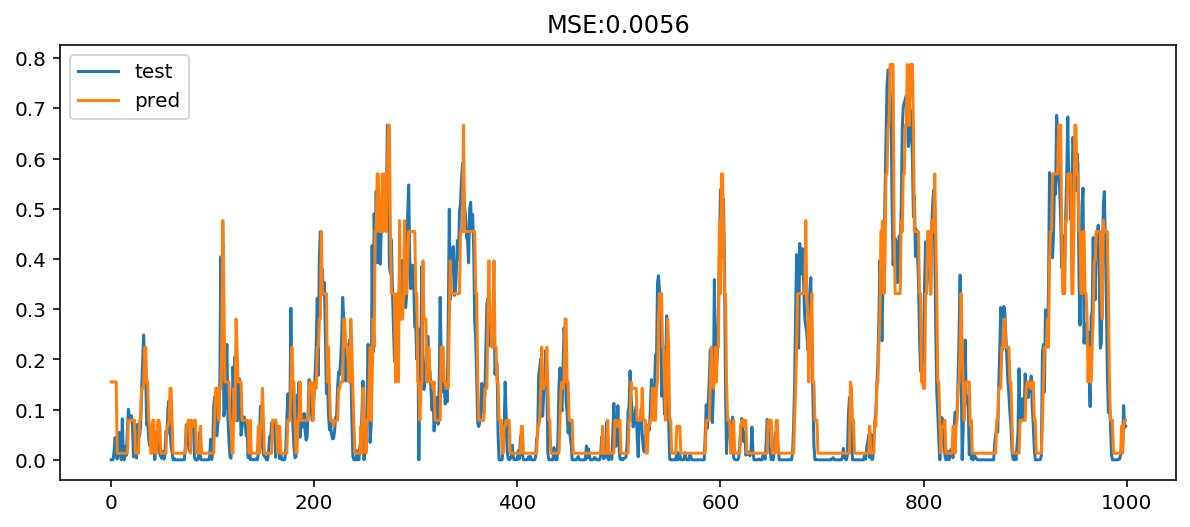

In [9]:
best_param = {'drop_time': 1.0, 
              'hour_num': 1.0, 
              'max_depth': 4.0, 
              'transform': 'ws*cos(wd)'}

best_esn_param = {'damping': 0.3,
                  'n_components': 1801,
                  'n_readout': 4001,
                  'weight_scaling': 0.4}

X_train, X_test, Y_train, Y_test, Y_Scaler = get_data(
    hour_num=int(best_param['hour_num']), 
    train_index=[6426, 10427], 
    test_index=[14389, 15390], 
    transform=best_param['transform'], 
    drop_time=bool(best_param['drop_time']), 
    scale=True, return_y_scaler=True)

base = esn_decision_tree_learner(
    n_readout=best_esn_param['n_readout'], 
    n_components=best_esn_param['n_components'], 
    damping=best_esn_param['damping'],
    weight_scaling=best_esn_param['weight_scaling'], 
    discard_steps=0, 
    random_state=None, 
    criterion="mse", 
    max_depth=best_param['max_depth'])

mse_list = []
for i in tqdm(np.arange(0,10)):
    mse = base_model_test(
        base, X_train, X_test, Y_train, Y_test, 
        plot_predict=False, 
        return_y_pred=False, 
        return_mse=True, 
        Y_scaler=None,
        verbose=False)
    mse_list.append(mse)

print('mean mse:', np.mean(mse_list))
base_model_test(base, X_train, X_test, Y_train, Y_test, plot_predict=True)

## grid_search

### input param and  max depth


get_data(hour_num=1, transform='ws*cos(wd)', drop_time=True, scale=True)

Input space: Index(['ws*cos(wd)', 'ws*cos(wd)-1', 'wind_power-1'], dtype='object')
train index: [6426, 10427] train_len: 4000
test index: [14389, 15390] test_len: 1000
best_param:
 {'drop_time': 1.0, 'hour_num': 1.0, 'max_depth': 4.0, 'mse': 0.005572914511324217, 'transform': 'ws*cos(wd)'} 

best_mse: 0.005572914511324217


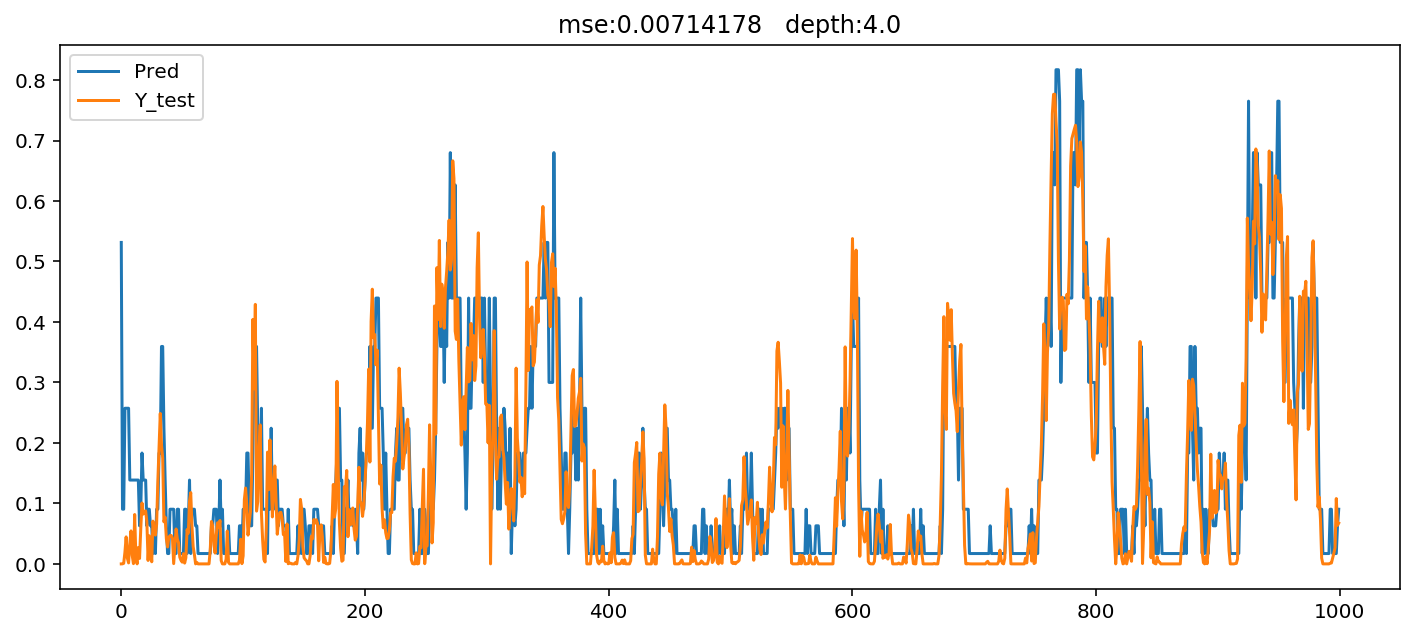

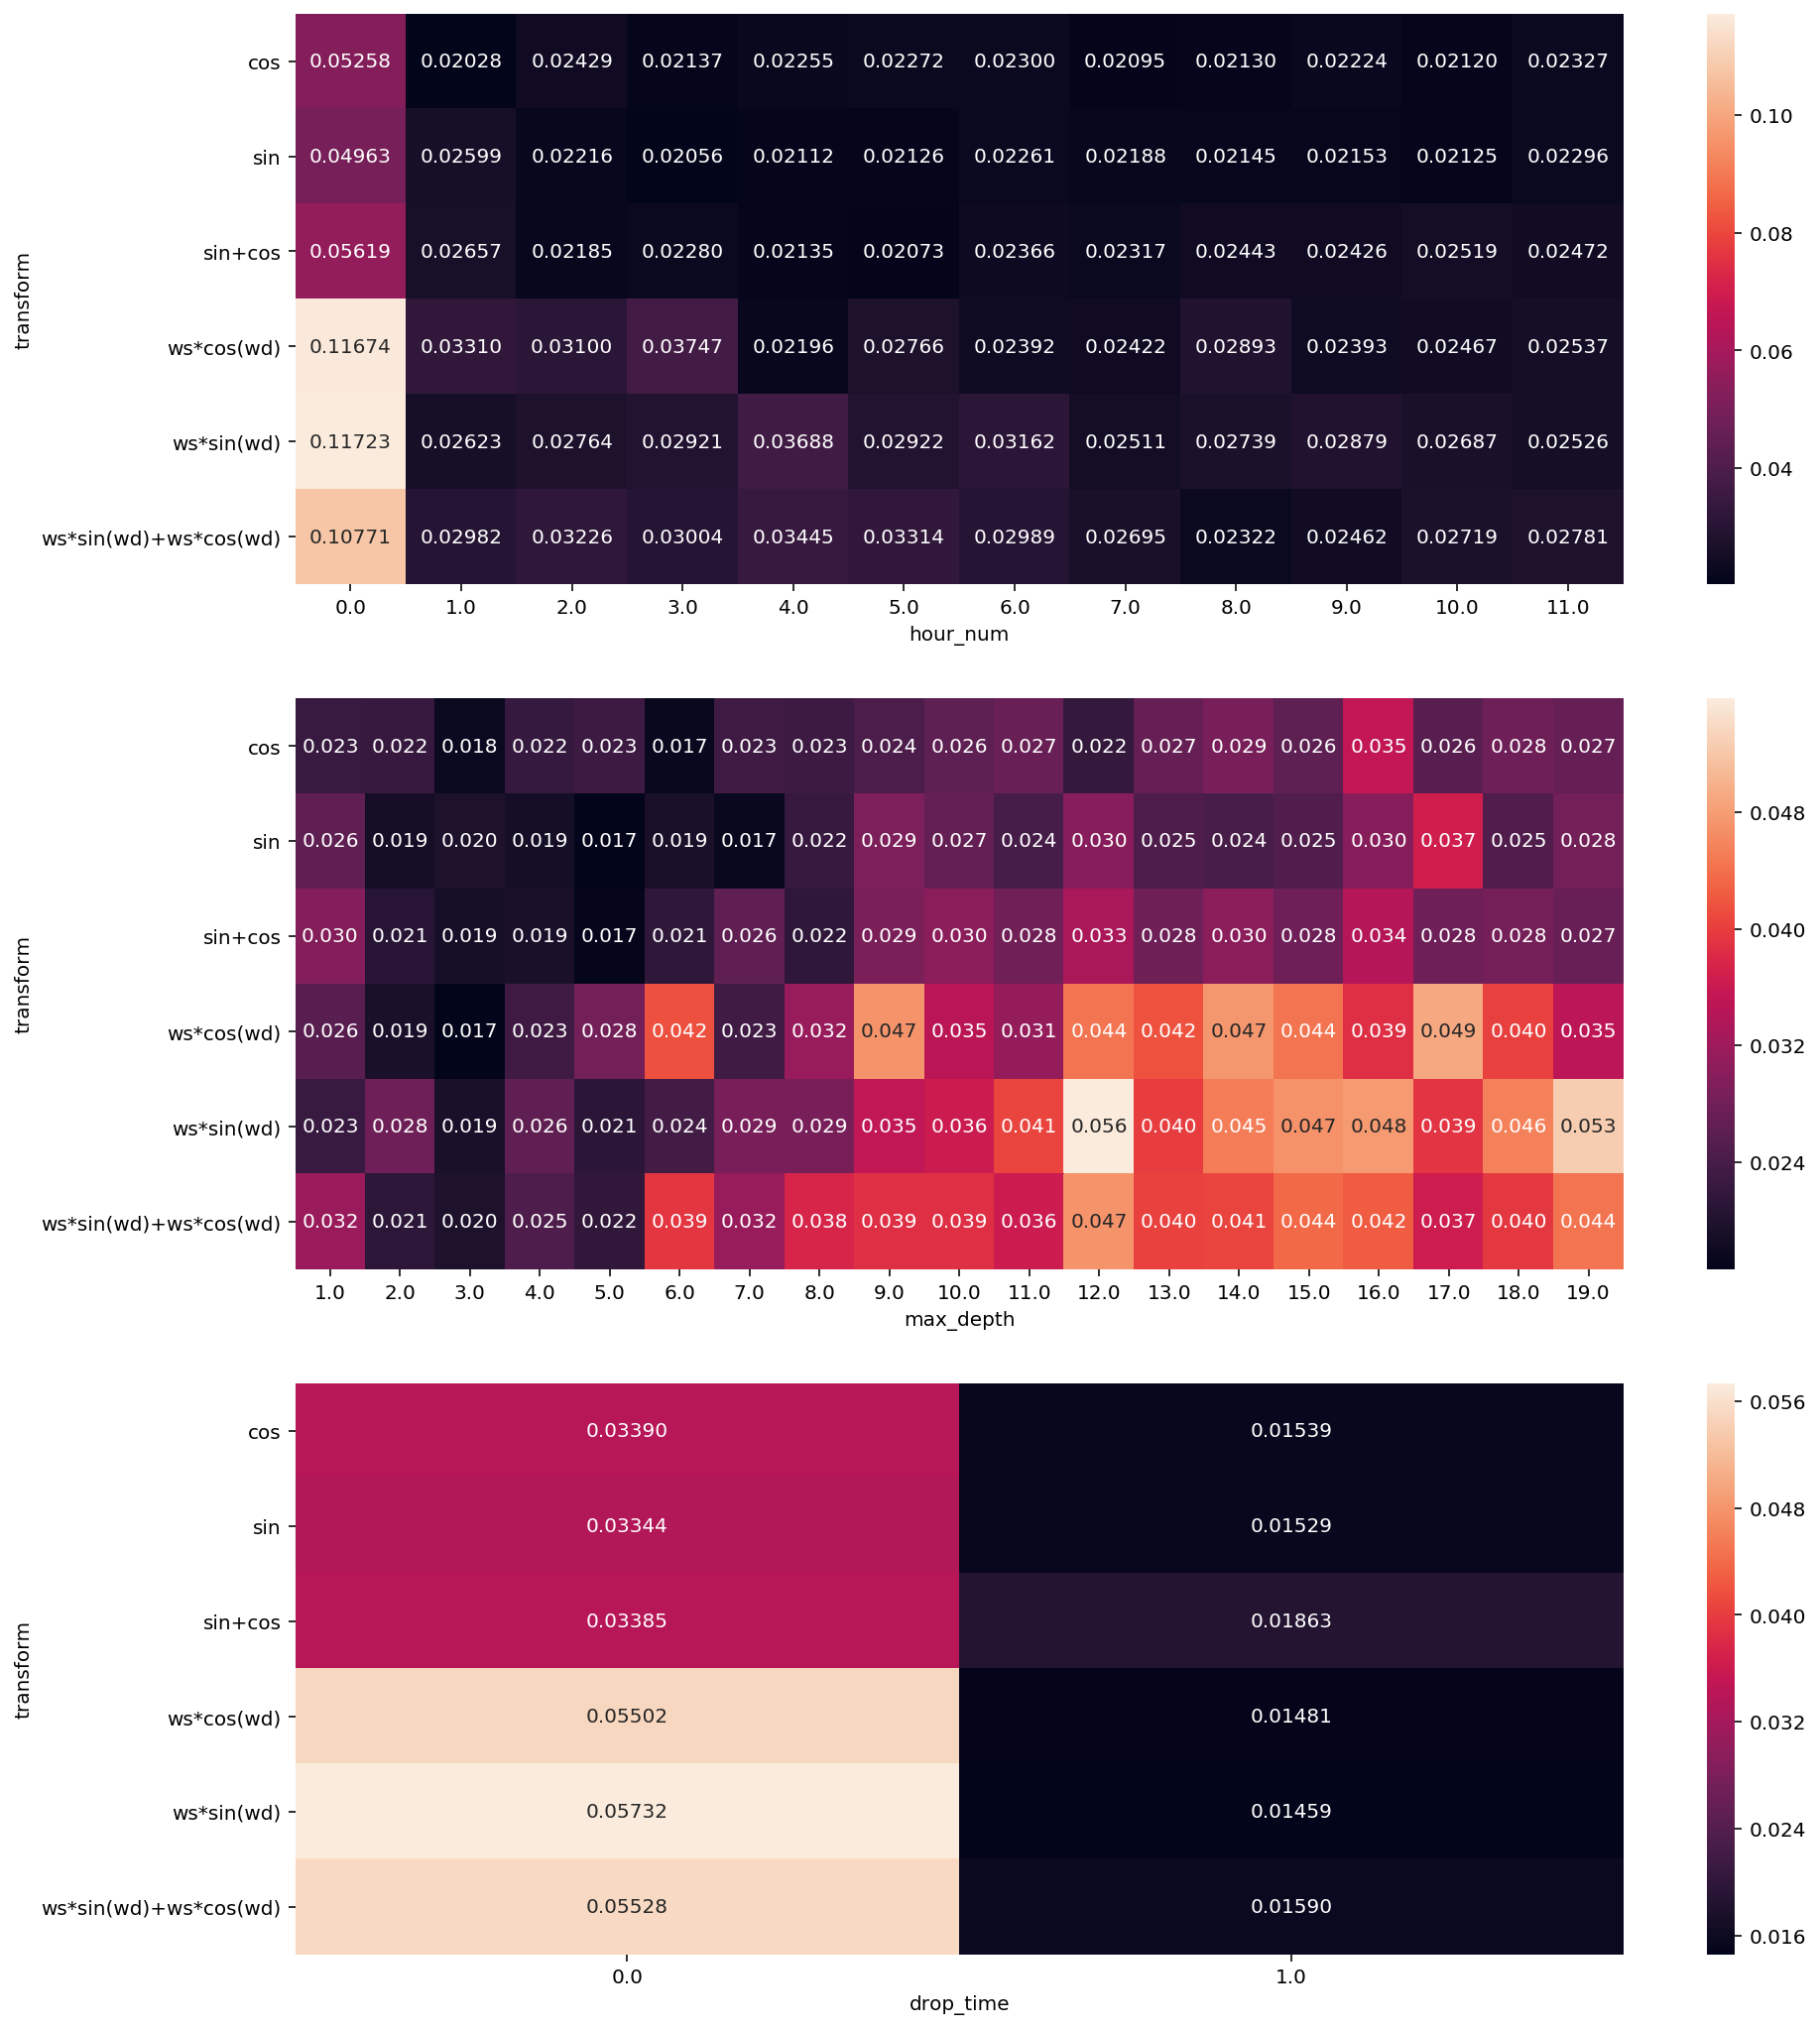

In [20]:
param_grid1 = {'transform': [None, 'sin', 'cos', 'sin+cos', 'ws*sin(wd)', 
                            'ws*cos(wd)', 'ws*sin(wd)+ws*cos(wd)'],
              'hour_num': np.arange(0,12),
              'drop_time': [True, False],
              'max_depth': np.arange(1,20)}
mse_df1, best_param1 = tree_grid_search1(param_grid1)
mse_df1.to_csv('mse_df1.csv')

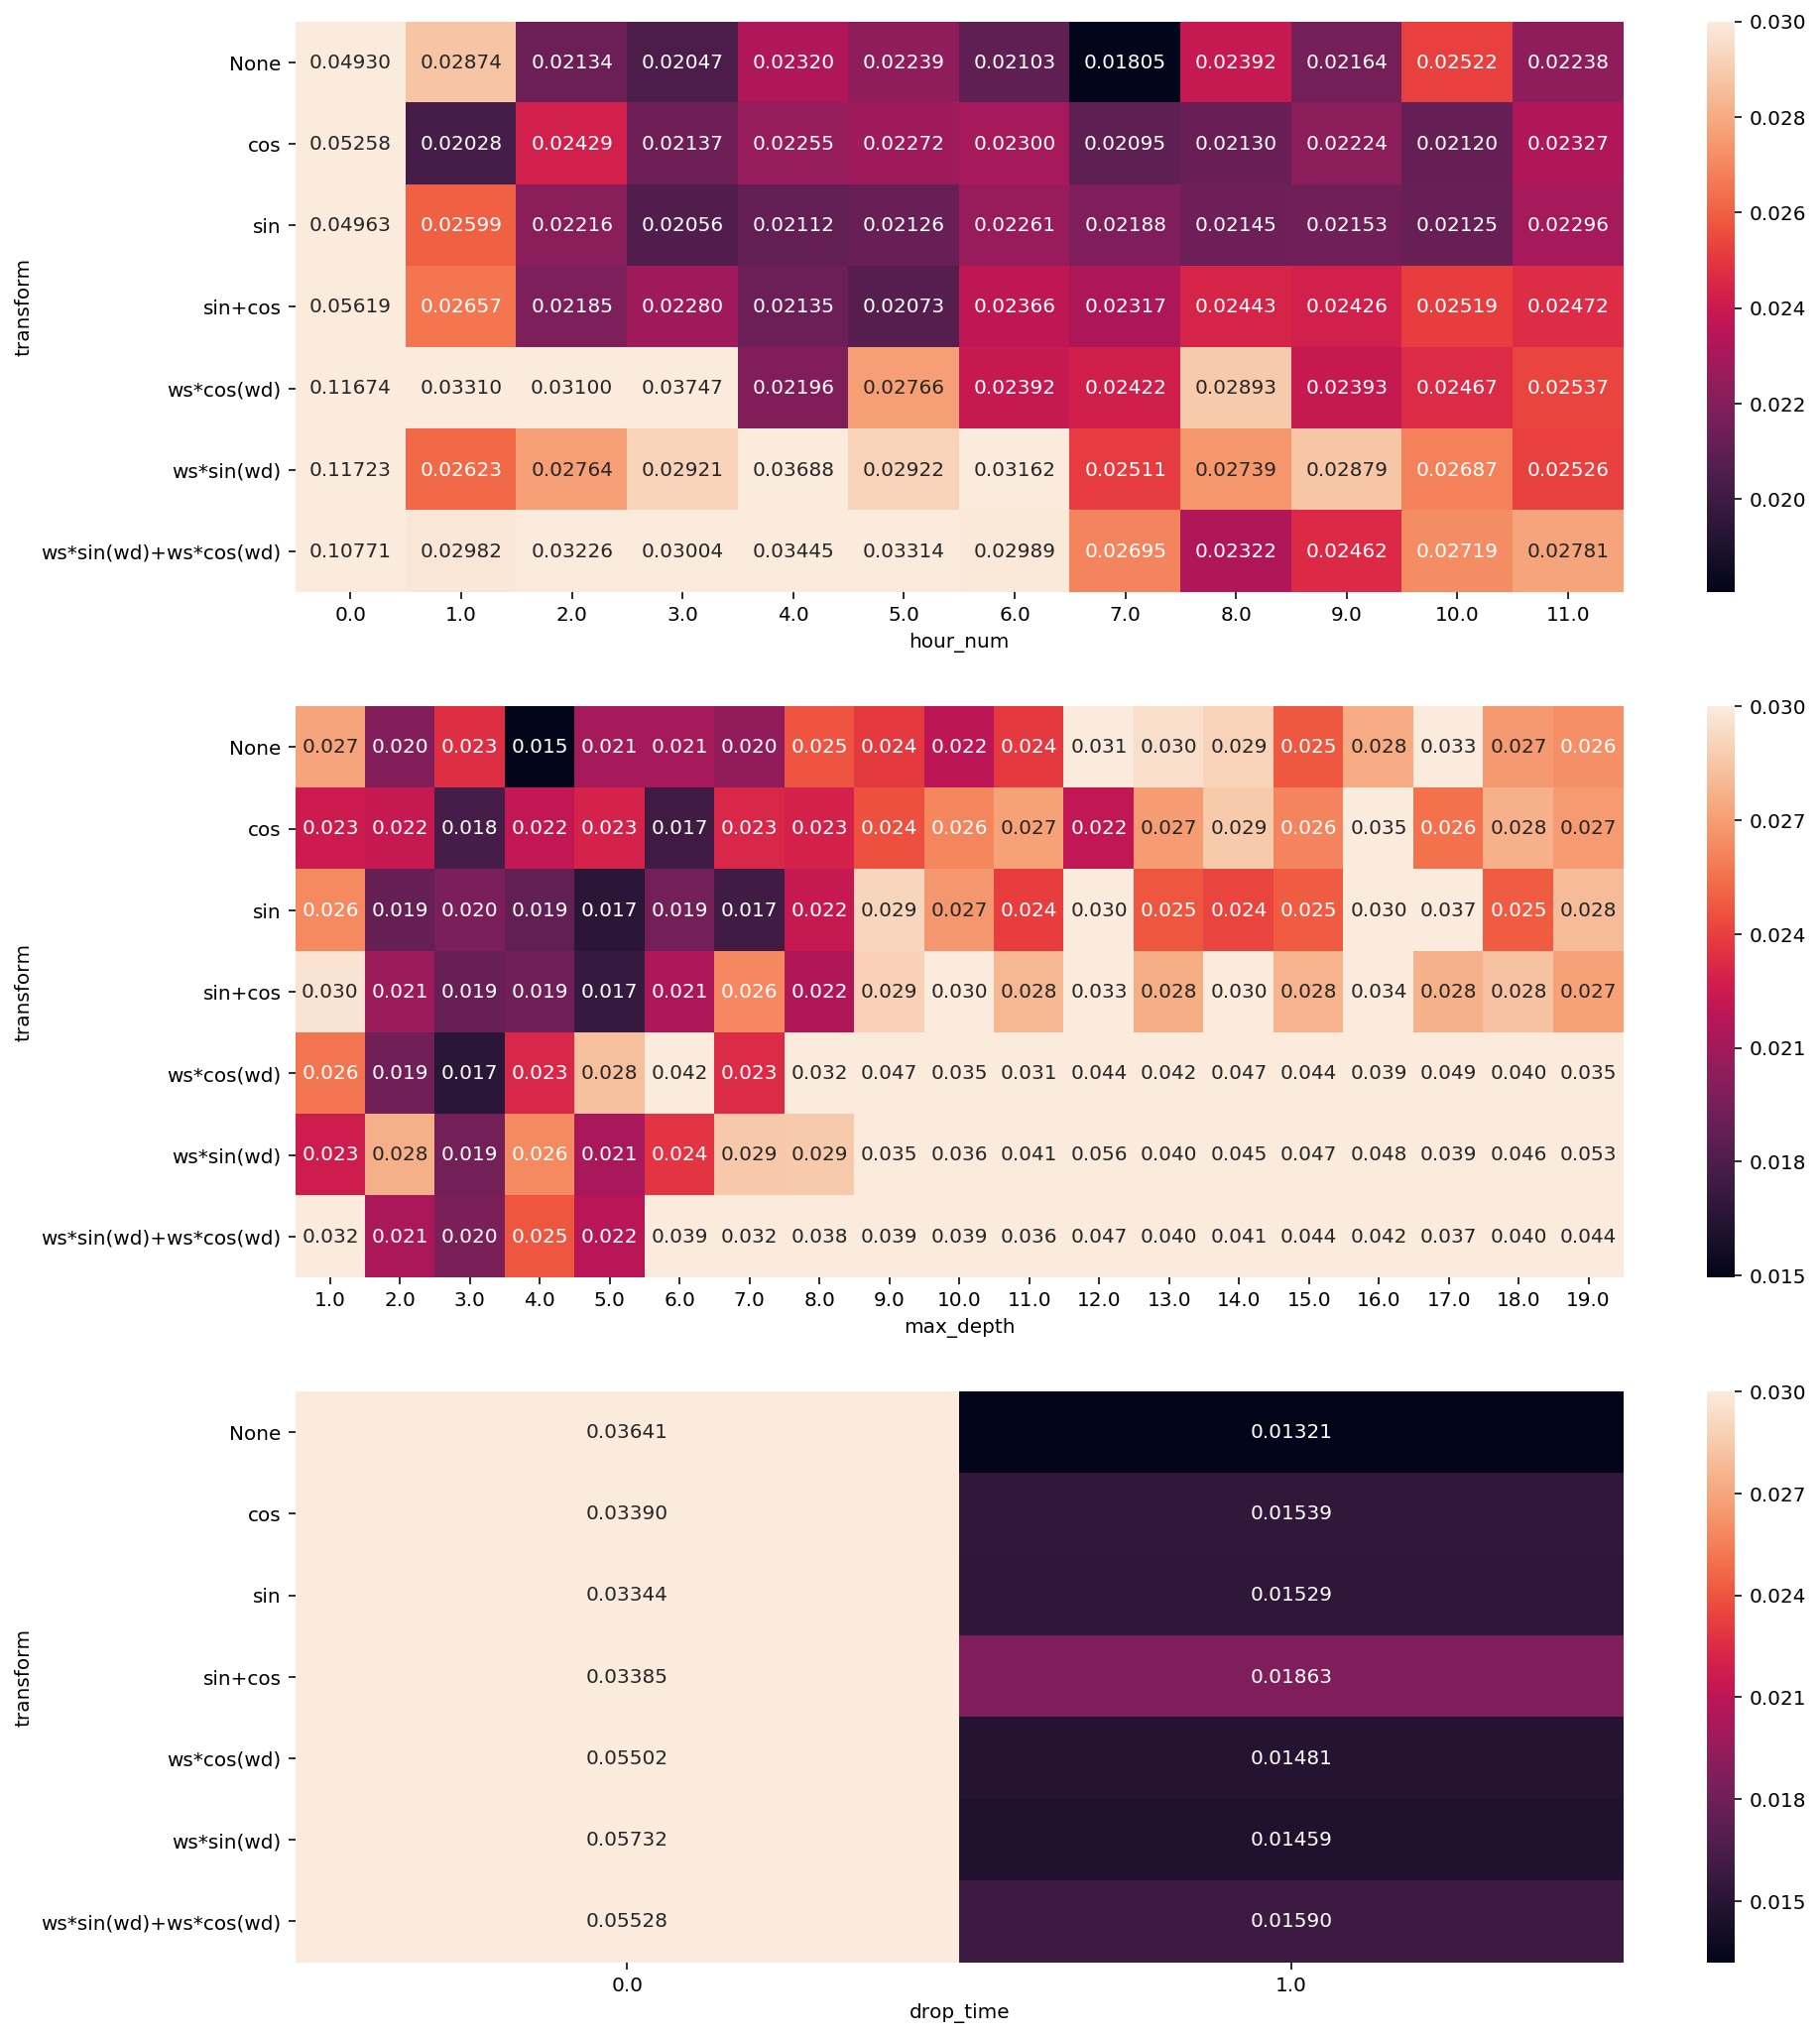

In [31]:
tree_heatmap1(mse_df1, vmax1=0.03, vmax2=0.03, vmax3=0.03)

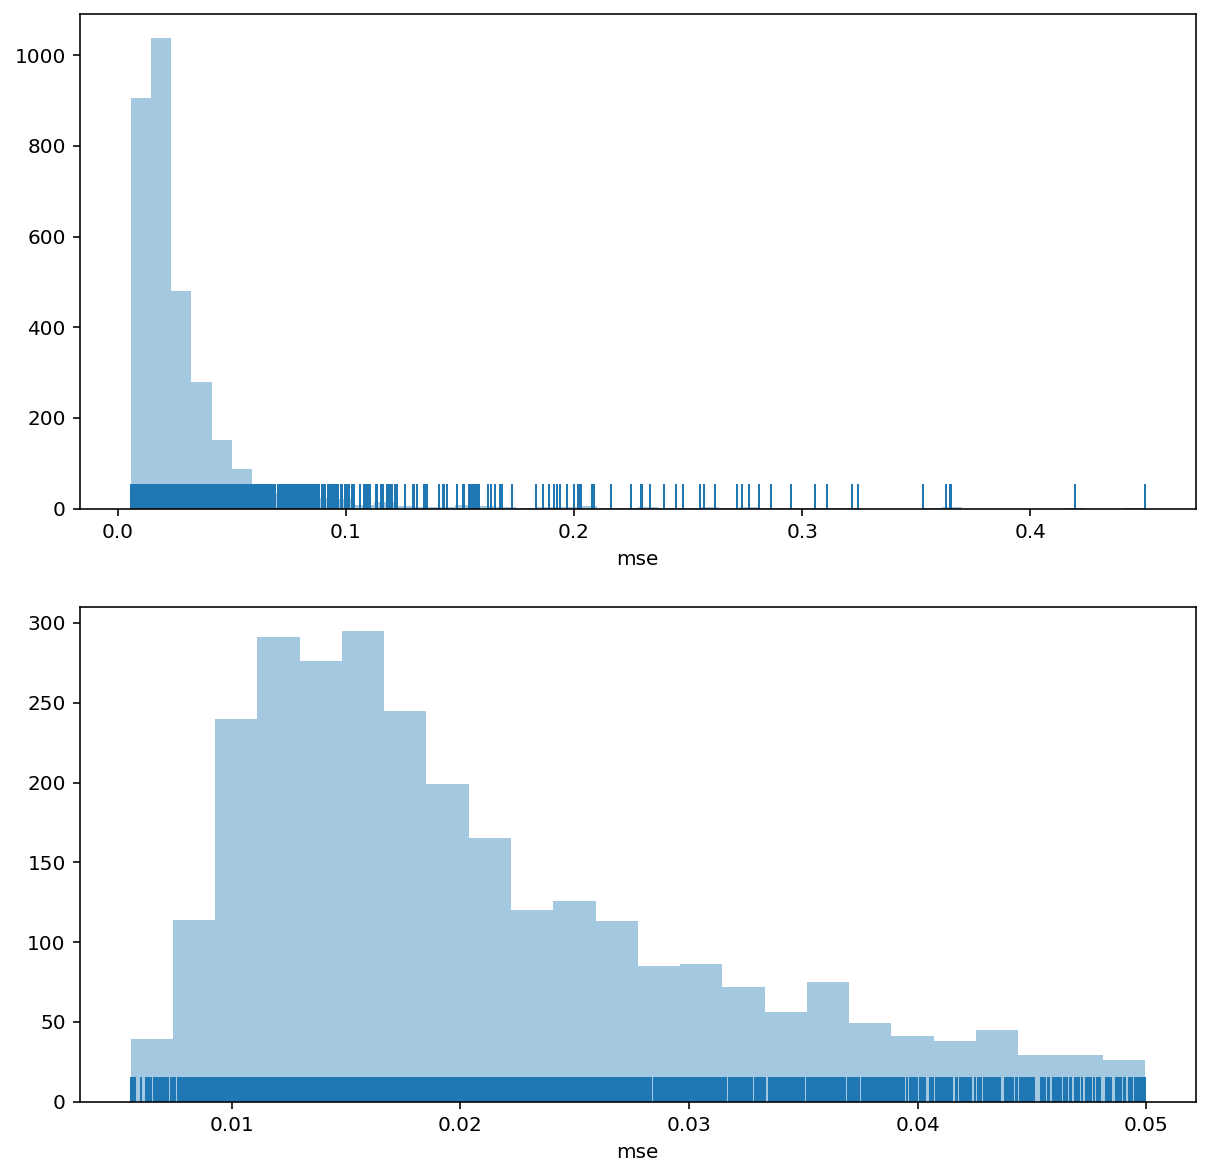

In [51]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
sns.distplot(mse_df1['mse'], kde=False, rug=True, ax=ax[0])
sns.distplot(mse_df1[mse_df1['mse']<0.05]['mse'], kde=False, rug=True, ax=ax[1])

get_data(hour_num=1, transform='ws*cos(wd)', drop_time=True, scale=True)

Input space: Index(['ws*cos(wd)', 'ws*cos(wd)-1', 'wind_power-1'], dtype='object')
train index: [6426, 10427] train_len: 4000
test index: [14389, 15390] test_len: 1000


Test MSE 0.0075338438418871235


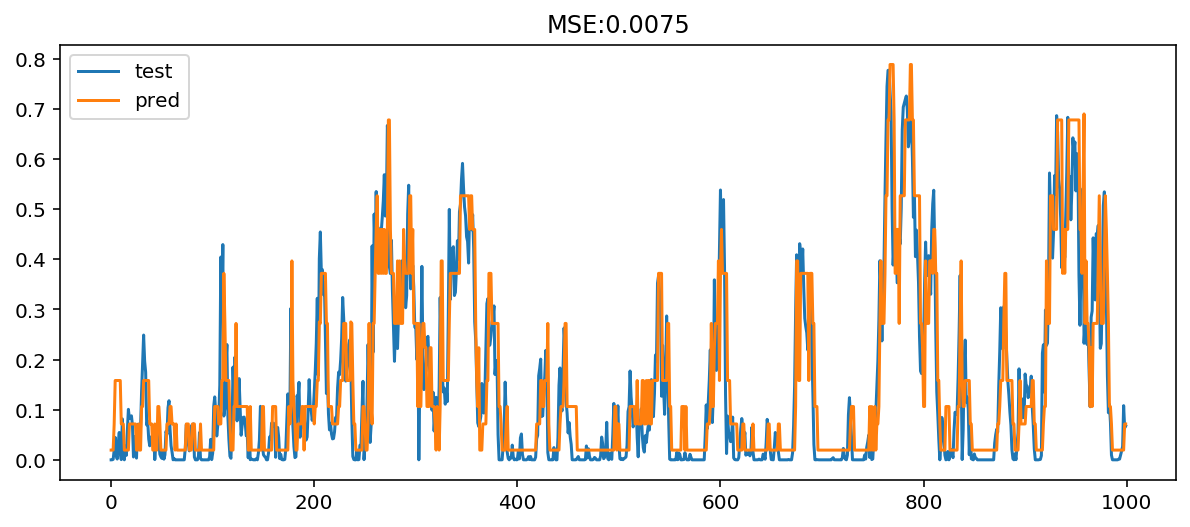

In [8]:
best_param = {'drop_time': 1.0, 
              'hour_num': 1.0, 
              'max_depth': 4.0, 
              'transform': 'ws*cos(wd)'}

X_train, X_test, Y_train, Y_test, Y_Scaler = get_data(
    hour_num=int(best_param['hour_num']), 
    train_index=[6426, 10427], 
    test_index=[14389, 15390], 
    transform=best_param['transform'], 
    drop_time=bool(best_param['drop_time']), 
    scale=True, return_y_scaler=True)

base = esn_decision_tree_learner( 
    discard_steps=0, 
    random_state=None, 
    criterion="mse", 
    max_depth=best_param['max_depth'])

base_model_test(base, X_train, X_test, Y_train, Y_test, plot_predict=True)

### esn param

In [8]:
best_param = {
    'drop_time': 1.0, 
    'hour_num': 1.0, 
    'max_depth': 4.0, 
    'transform': 'ws*cos(wd)'} 
X_train, X_test, Y_train, Y_test, Y_Scaler = get_data(
    hour_num=int(best_param['hour_num']), 
    train_index=[6426, 9427], 
    test_index=[14389, 15390], 
    transform=best_param['transform'], 
    drop_time=bool(best_param['drop_time']), 
    scale=True, return_y_scaler=True)

base = esn_decision_tree_learner( 
    discard_steps=0, 
    random_state=None, 
    criterion="mse", 
    max_depth=best_param['max_depth'])

get_data(hour_num=1, transform='ws*cos(wd)', drop_time=True, scale=True)

Input space: Index(['ws*cos(wd)', 'ws*cos(wd)-1', 'wind_power-1'], dtype='object')
train index: [6426, 9427] train_len: 3000
test index: [14389, 15390] test_len: 1000


In [9]:
esn_param = {
    'n_readout': np.arange(1,10000,1000), 
    'n_components': np.arange(1,2000,100), 
    'damping': np.arange(0,1,0.1),
    'weight_scaling': np.arange(0,1,0.1)}

from sklearn.model_selection import GridSearchCV
from collections import defaultdict
grid_search = GridSearchCV(
    estimator=base, param_grid=esn_param, 
    scoring='neg_mean_squared_error', n_jobs=-1, iid='warn', 
    refit=True, cv=3, verbose=10, 
    return_train_score=True)

In [10]:
grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 20000 candidates, totalling 60000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

[Parallel(n_jobs=-1)]: Done 9105 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-1)]: Done 9240 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 9377 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done 9514 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 9653 tasks      | elapsed: 33.1min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done 9933 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done 10074 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-1)]: Done 10217 tasks      | elapsed: 34.9min
[Parallel(n_jobs=-1)]: Done 10360 tasks      | elapsed: 35.3min
[Parallel(n_jobs=-1)]: Done 10505 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done 10650 tasks      | elapsed: 36.2min
[Parallel(n_jobs=-1)]: Done 10797 tasks      | elapsed: 36.6min
[Parallel(n_jobs=-1)]: Done 10944 tasks      | elapsed: 37.1min
[Parallel(n_jobs=-1)]: Done 11093 tasks      | elapsed: 37.6min
[Parallel(n_jobs=-1)]: Done 11242 tasks      | 

[Parallel(n_jobs=-1)]: Done 34840 tasks      | elapsed: 103.6min
[Parallel(n_jobs=-1)]: Done 35105 tasks      | elapsed: 104.2min
[Parallel(n_jobs=-1)]: Done 35370 tasks      | elapsed: 104.9min
[Parallel(n_jobs=-1)]: Done 35637 tasks      | elapsed: 105.6min
[Parallel(n_jobs=-1)]: Done 35904 tasks      | elapsed: 106.3min
[Parallel(n_jobs=-1)]: Done 36173 tasks      | elapsed: 107.0min
[Parallel(n_jobs=-1)]: Done 36442 tasks      | elapsed: 107.7min
[Parallel(n_jobs=-1)]: Done 36713 tasks      | elapsed: 108.4min
[Parallel(n_jobs=-1)]: Done 36984 tasks      | elapsed: 109.1min
[Parallel(n_jobs=-1)]: Done 37257 tasks      | elapsed: 109.8min
[Parallel(n_jobs=-1)]: Done 37530 tasks      | elapsed: 110.5min
[Parallel(n_jobs=-1)]: Done 37805 tasks      | elapsed: 111.2min
[Parallel(n_jobs=-1)]: Done 38080 tasks      | elapsed: 111.9min
[Parallel(n_jobs=-1)]: Done 38357 tasks      | elapsed: 112.6min
[Parallel(n_jobs=-1)]: Done 38634 tasks      | elapsed: 113.3min
[Parallel(n_jobs=-1)]: Do

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<ngboost.esn_learners.ESN_decision_tree_learner object at 0x1a21e99ba8>,
             iid='warn', n_jobs=-1,
             param_grid={'damping': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'n_components': array([   1,  101,  201,  301,  401,  501,  601,  701,  801,  901, 1001,
       1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901]),
                         'n_readout': array([   1, 1001, 2001, 3001, 4001, 5001, 6001, 7001, 8001, 9001]),
                         'weight_scaling': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=10)

In [14]:
esn_grid_search_result = pd.DataFrame(grid_search.cv_results_)
esn_grid_search_result.to_csv('esn_grid_search_result.csv')

In [16]:
grid_search.best_params_

{'damping': 0.30000000000000004,
 'n_components': 1801,
 'n_readout': 4001,
 'weight_scaling': 0.4}

In [15]:
grid_search.best_score_

-0.012679394816055217

In [17]:
esn_grid_search_result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_damping,param_n_components,param_n_readout,param_weight_scaling,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.611124,0.007279,0.051316,0.001759,0,1,1,0,"{'damping': 0.0, 'n_components': 1, 'n_readout...",-0.010050,-0.011159,-0.020837,-0.014015,0.004845,17532,-1.054478e-08,-6.501236e-09,-1.395897e-08,-1.033500e-08,3.048220e-09
1,0.601209,0.005316,0.044034,0.004273,0,1,1,0.1,"{'damping': 0.0, 'n_components': 1, 'n_readout...",-0.010206,-0.010724,-0.019284,-0.013405,0.004163,2082,-1.054478e-08,-6.501236e-09,-1.395897e-08,-1.033500e-08,3.048220e-09
2,0.611719,0.068633,0.054258,0.001867,0,1,1,0.2,"{'damping': 0.0, 'n_components': 1, 'n_readout...",-0.010342,-0.011276,-0.019660,-0.013759,0.004190,11253,-1.054478e-08,-6.501236e-09,-1.395897e-08,-1.033500e-08,3.048220e-09
3,0.684036,0.012248,0.052567,0.005128,0,1,1,0.3,"{'damping': 0.0, 'n_components': 1, 'n_readout...",-0.009982,-0.010737,-0.020573,-0.013764,0.004825,11425,-1.054478e-08,-6.501236e-09,-1.395897e-08,-1.033500e-08,3.048220e-09
4,0.667531,0.019375,0.083732,0.009048,0,1,1,0.4,"{'damping': 0.0, 'n_components': 1, 'n_readout...",-0.010435,-0.011365,-0.019584,-0.013795,0.004111,12302,-1.054478e-08,-6.501236e-09,-1.395897e-08,-1.033500e-08,3.048220e-09


In [9]:
esn_grid_search_result = pd.read_csv('result/esn_grid_search_result.csv')

In [10]:
esn_grid_search_result['mean_test_score'] = -esn_grid_search_result['mean_test_score']

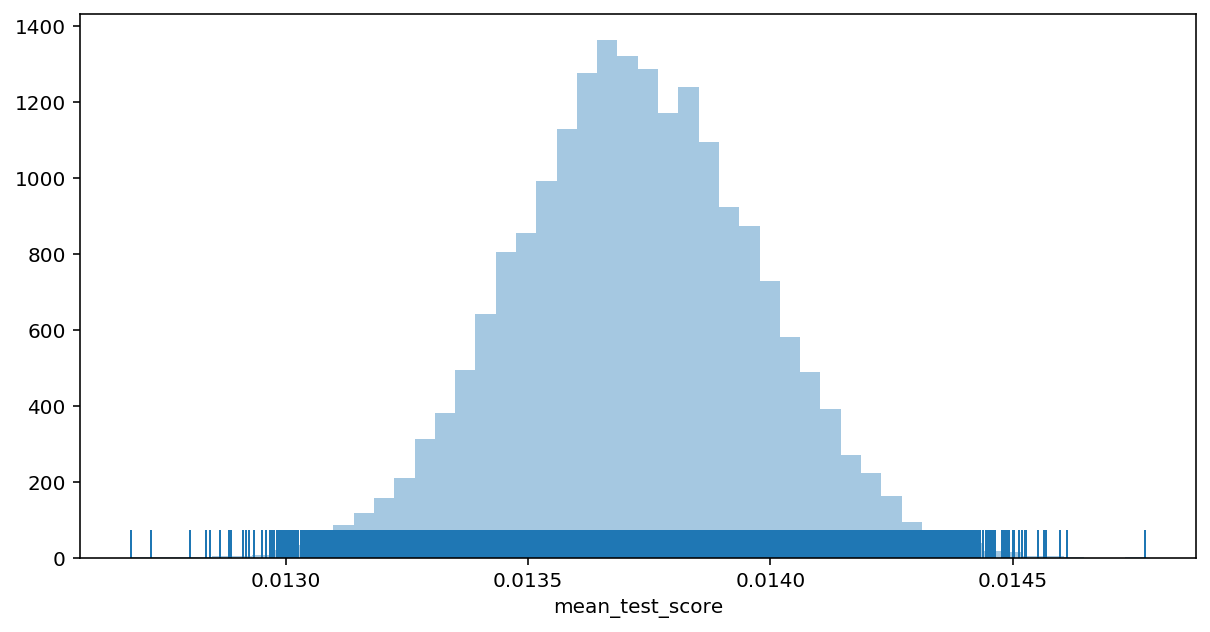

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.distplot(esn_grid_search_result['mean_test_score'], kde=False, rug=True, ax=ax)

In [16]:
esn_grid_search_result[['param_damping','param_weight_scaling']] = \
round(esn_grid_search_result[['param_damping','param_weight_scaling']], 2)

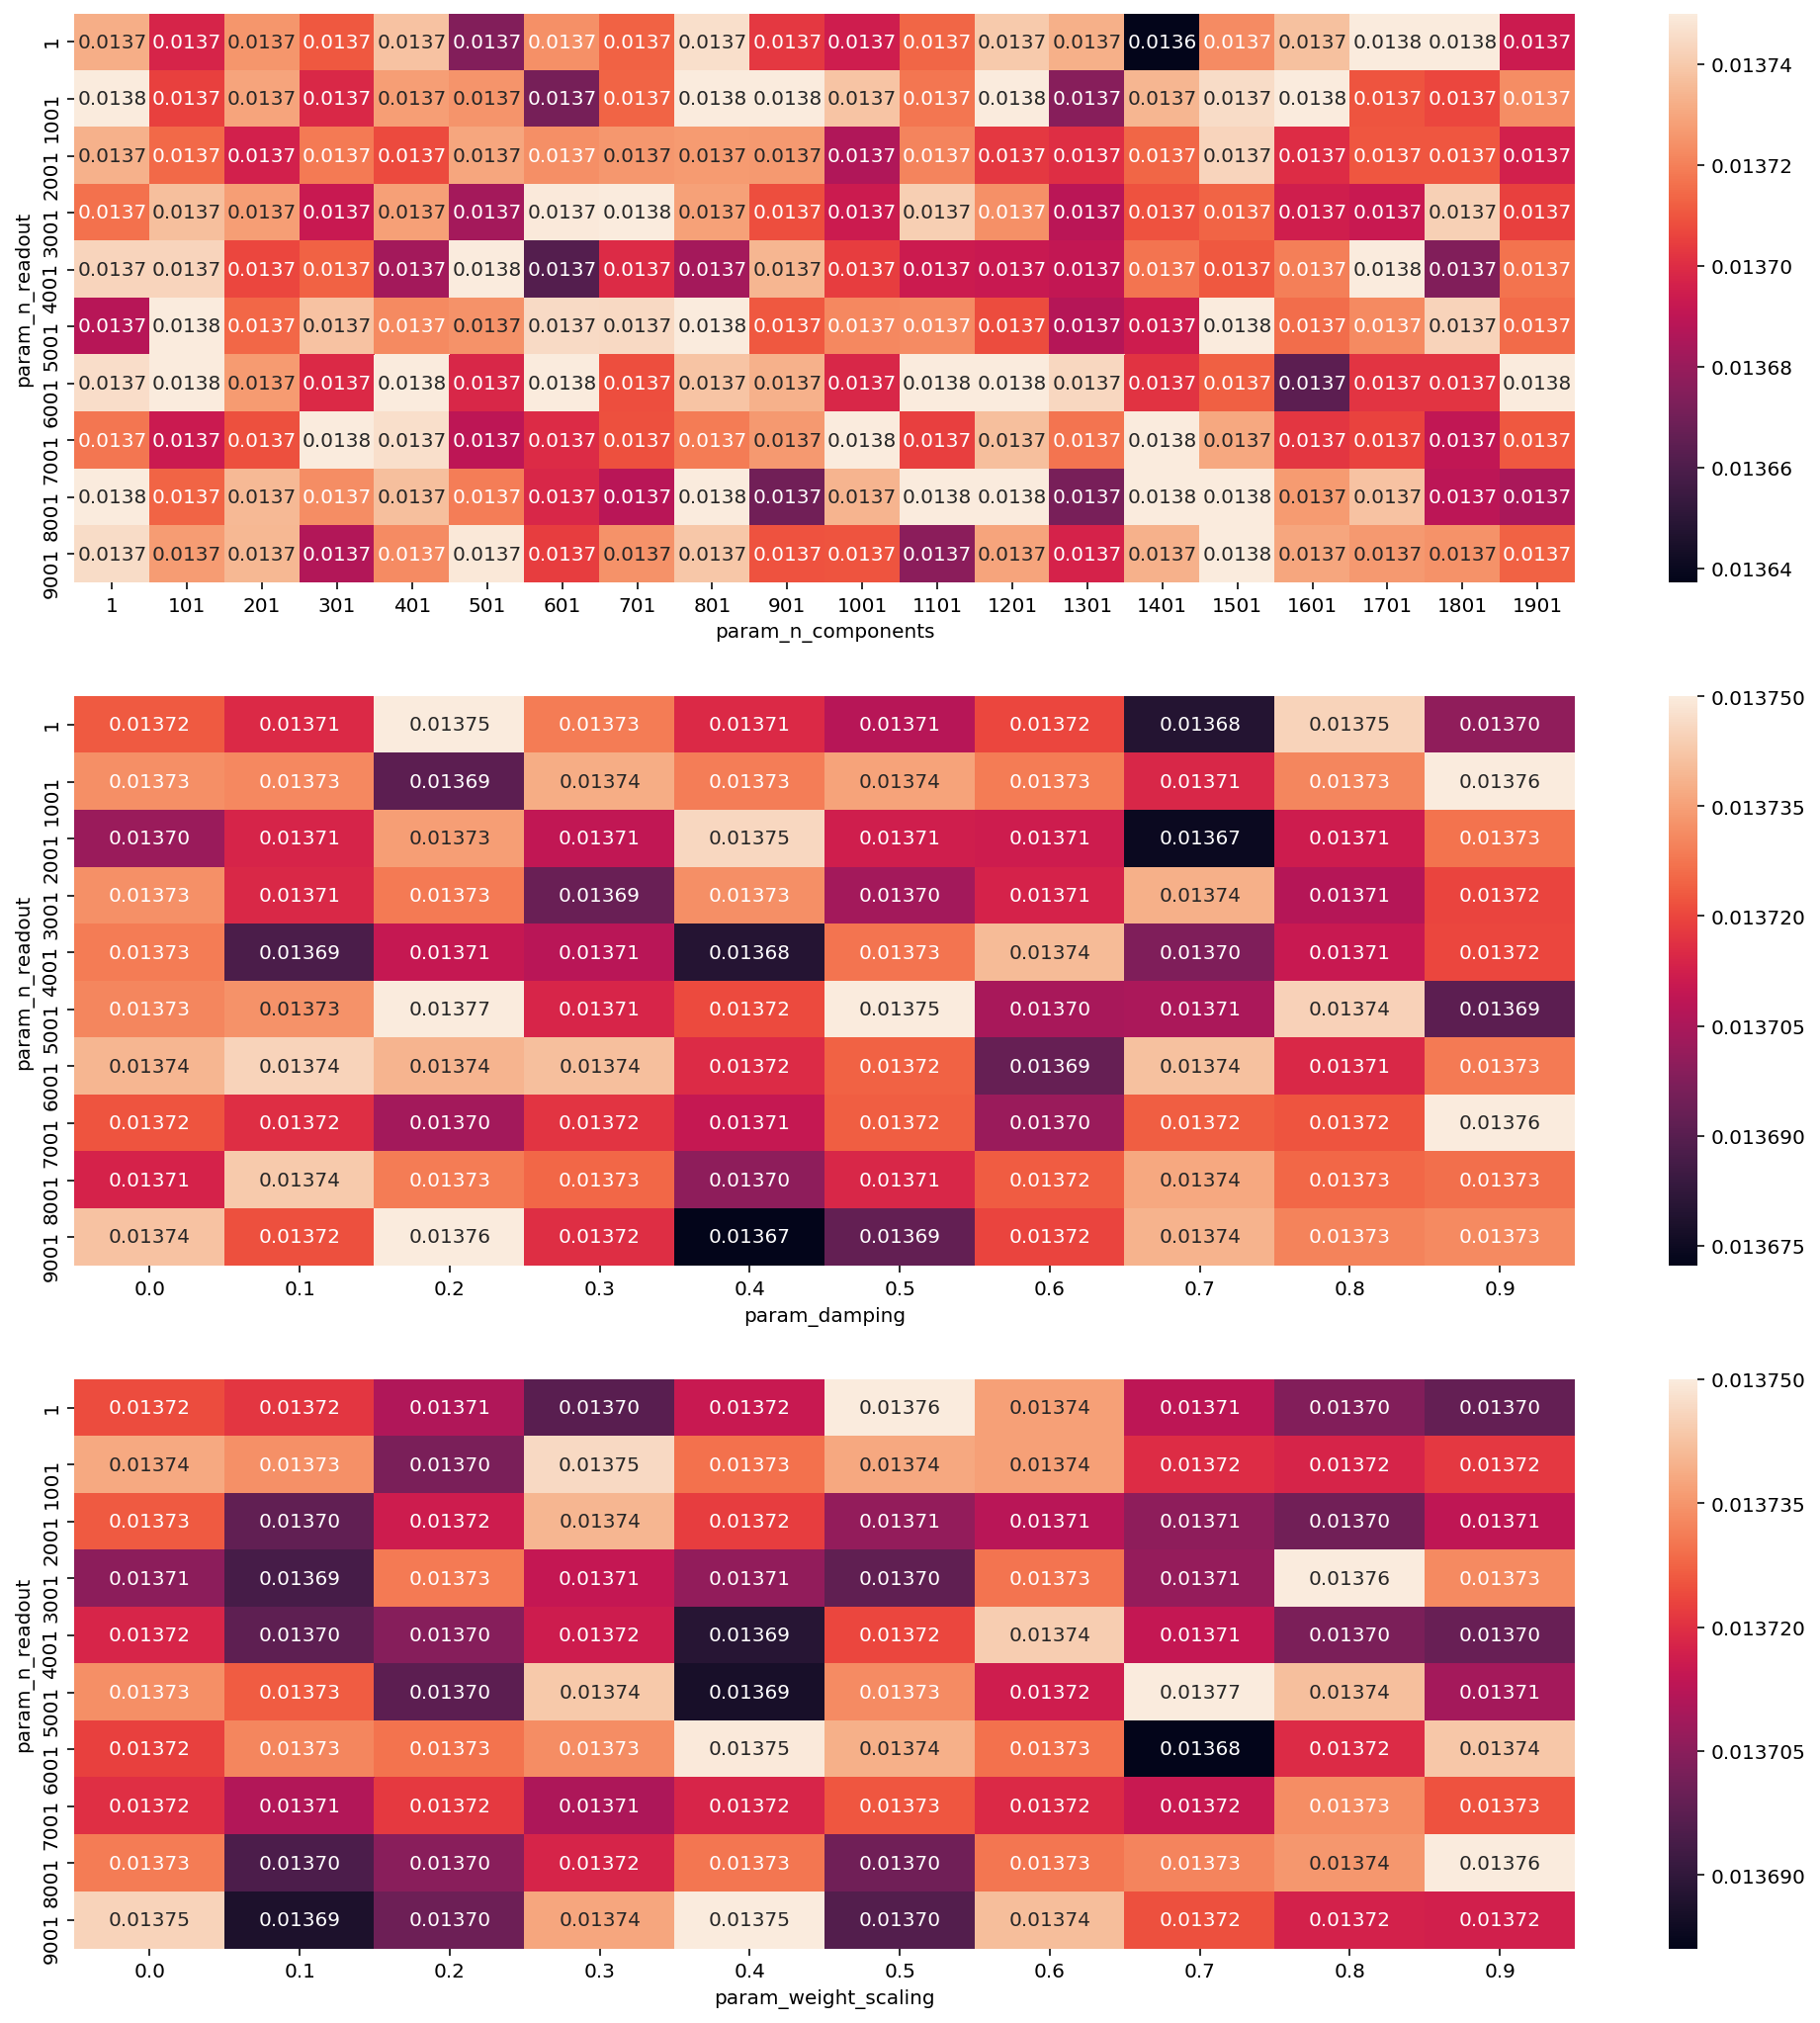

In [17]:
f, ax= plt.subplots(figsize=(17,18),nrows=3)
sns.heatmap(esn_grid_search_result.groupby(['param_n_readout','param_n_components'])\
            ['mean_test_score'].mean().unstack(),
            ax=ax[0], vmax=0.01375, annot=True, fmt='.4f')
sns.heatmap(esn_grid_search_result.groupby(['param_n_readout','param_damping'])\
            ['mean_test_score'].mean().unstack(),
            ax=ax[1], vmax=0.01375, annot=True, fmt='.5f')
sns.heatmap(esn_grid_search_result.groupby(['param_n_readout','param_weight_scaling'])\
            ['mean_test_score'].mean().unstack(),
            ax=ax[2], vmax=0.01375, annot=True, fmt='.5f')